In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle
from portraits.utils import read_dataset
from portraits.plotting import axis_net, line_palette_annotation_plot
import numpy as np
import seaborn as sns
import matplotlib

/home/jovyan/projects/TKI_IO_perdictor_Stupichev/RCC.AI_TKI_IO.Hsieh/TME_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and Inspecting a Pretrained Model

In [2]:
# Upload the model dictionary
with open('Data/ccrcc_io_0.3.pickle', "rb") as f:
    model_dict = pickle.load(f)
model_dict.keys()

dict_keys(['model', 'features', 'validation_datasets', 'X_val_raw', 'meta_annotation', 'palette_projects'])

In [3]:
# Extract components from the model dictionary:
# - model: the trained predictive model
# - features: feature list used for training and inference
# - validation_datasets: datasets used for model validation
# - X_val_raw: raw input features for the validation set (before preprocessing)
# - meta_annotation: metadata or clinical annotations associated with samples
# - io_pal: color palette for immune/other classification
# - bin_palette_black / bin_palette_black2: binary color palettes (e.g., black/white variants)
# - ds_pal: color palette for different datasets
# - recist_palette: color palette for RECIST response categories (CR, PR, SD, PD, NaN)

model = model_dict['model']
features = model_dict['features']
validation_datasets = model_dict['validation_datasets']
X_val_raw = model_dict['X_val_raw']
meta_annotation = model_dict['meta_annotation']
io_pal = model_dict['palette_projects']['io_pal']
bin_palette_black = model_dict['palette_projects']['bin_palette_black']
bin_palette_black2 = model_dict['palette_projects']['bin_palette_black2']
ds_pal = model_dict['palette_projects']['ds_pal']
recist_palette = model_dict['palette_projects']['recist_palette']


# Exclude Biologically Defined Non-Responders and Compute Model Predictions

In [4]:
# Identify non-responder (NR) samples in the validation set based on specific biological features:
# - Antigen presentation failure (Antigen_present_failure_from_Kr == 1)
# - MTOR pathway activation (MTOR_from_Kr == 1)
# - High myogenesis signature (Myogenesis >= 15)
# The indices of these samples are stored in NR_samples_val.

NR_samples_val = X_val_raw[
    (X_val_raw['Antigen_present_failure_from_Kr'] == 1) | \
    (X_val_raw['MTOR_from_Kr'] == 1) | \
    (X_val_raw['Myogenesis'] >= 15)
].index
                   
len(NR_samples_val)
X_val = X_val_raw.loc[X_val_raw.index ^ NR_samples_val]
X_val.shape

/tmp/ipykernel_5838/3144213827.py:14: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  X_val = X_val_raw.loc[X_val_raw.index ^ NR_samples_val]


(1165, 17)

In [5]:
# Select only the features required by the model from the validation data
X_val_selected = X_val[features]

# Display the shape of the selected validation feature matrix
display(X_val_selected.shape)

# Predict response probabilities using the trained model
# Keep only the probability of the positive class (index [1]) and rename the column
val_prediction = pd.DataFrame(model.predict_proba(X_val_selected), 
                              index=X_val_selected.index)[1].rename('Response\nscore')

# Output the number of predictions made (should match the number of samples in X_val_selected)
len(val_prediction)


(1165, 5)

1165

# IO Response Heatmap with Molecular and Clinical Annotations

/tmp/ipykernel_5838/2733355835.py:21: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  so = list((X_val_raw.index ^ X_val_selected.index) & jav_io_samples) + \
/tmp/ipykernel_5838/2733355835.py:21: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  so = list((X_val_raw.index ^ X_val_selected.index) & jav_io_samples) + \


<Axes: ylabel='Mutation in AP'>

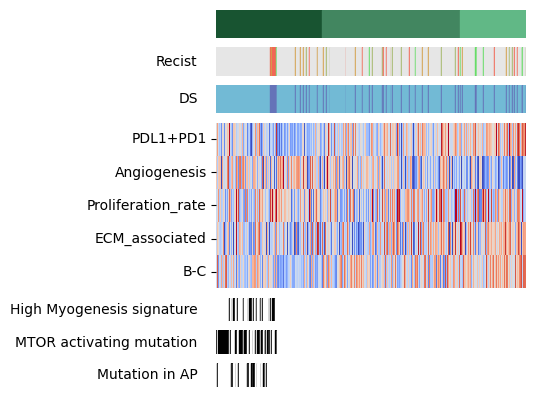

In [6]:
# Set the default colormap for heatmap visualization
default_cmap = matplotlib.cm.coolwarm

# Create a custom multi-axis layout using axis_net
# It defines a grid with 7 rows of specified relative heights
af = axis_net(1, 7, y_len=.7, 
              gridspec_kw={'height_ratios': [.6, .6, .6, 3.5, .5, .5, .5]}, x_len=4)

# Use raw validation data (before NR filtering)
X_tmp = X_val_raw

# Select samples from the JAVELIN and WU cohorts treated with IO or IO+TKI
jav_io_samples = meta_annotation[
    (meta_annotation.DS.isin(['ccRCC_JAVELIN_101', 'WU_ccRCC_RCCTC'])) & 
    (meta_annotation.Treatment_category.isin(['IO', 'IO+TKI']))
].index

# Define sort order:
#   1. Start with samples excluded as NR but in the JAVELIN IO set
#   2. Then add sorted predictions for remaining JAVELIN IO samples
so = list((X_val_raw.index ^ X_val_selected.index) & jav_io_samples) + \
     list(val_prediction.reindex(jav_io_samples).dropna().sort_values().index)

# Categorize response score into LOW / MED / HIGH for visualization
tmp = pd.Series(
    ['LOW' if x < 0.1 else 'HIGH' if x > 0.4 else 'MED' for x in val_prediction],
    index=val_prediction.index
)

# Plot response score category (LOW/MED/HIGH) using the IO palette
line_palette_annotation_plot(tmp.reindex(so).replace(np.nan, 'LOW'), palette=io_pal, ax=next(af))

# Plot RECIST response category (CR, PR, SD, PD, NaN) using recist palette
line_palette_annotation_plot(meta_annotation.Recist.reindex(so).fillna('NaN'), 
                             palette=recist_palette, ax=next(af))

# Plot dataset origin using dataset palette
line_palette_annotation_plot(meta_annotation.DS[so], palette=ds_pal, ax=next(af))

# Plot heatmap of selected biological signatures (transposed for horizontal sample layout)
sns.heatmap(
    X_tmp[['PDL1+PD1', 'Angiogenesis', 'Proliferation_rate', 'ECM_associated', 'B-C']].T[so], 
    cmap=default_cmap, vmin=-2, vmax=2, ax=next(af), cbar=False, xticklabels=[]
)

# Plot binary annotations for biological mechanisms associated with non-response
line_palette_annotation_plot(
    (X_tmp.reindex(so)['Myogenesis'] > 15).rename("High Myogenesis signature"), 
    palette=bin_palette_black, ax=next(af)
)

line_palette_annotation_plot(
    X_tmp.reindex(so)['MTOR_from_Kr'].rename("MTOR activating mutation"), 
    palette=bin_palette_black2, ax=next(af)
)

line_palette_annotation_plot(
    X_tmp.reindex(so)['Antigen_present_failure_from_Kr'].rename("Mutation in AP"), 
    palette=bin_palette_black2, ax=next(af)
)

# Optional: Save the figure
# save_plt('NGS part plots/Fig5/IO_test_overall_heatmap')
